<a href="https://colab.research.google.com/github/packtpublishing/Machine-Learning-for-Imbalanced-Data/blob/main/chapter07/cutmix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
import random
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


def generate_mixing_ratio(beta_distribution=1.0):
    return np.random.beta(beta_distribution, beta_distribution)


def compute_patch_dimensions(image_height, image_width, mixing_ratio):
    box_width = int(image_width * np.sqrt(1.0 - mixing_ratio))
    box_height = int(image_height * np.sqrt(1.0 - mixing_ratio))
    return box_height, box_width


def get_random_corner(box_height, box_width, image_height, image_width):
    corner_x = np.random.randint(0, image_width - box_width + 1)
    corner_y = np.random.randint(0, image_height - box_height + 1)
    return corner_x, corner_y


def cutmix_image_and_label(image1, label1, image2, label2, beta_distribution=1.0):
    # Generate mixing ratio
    mixing_ratio = generate_mixing_ratio(beta_distribution)

    # Determine image dimensions
    image_height, image_width = image1.shape[1:]

    # Compute patch dimensions
    box_height, box_width = compute_patch_dimensions(
        image_height, image_width, mixing_ratio
    )

    # Get random top-left corner for the patch
    corner_x, corner_y = get_random_corner(
        box_height, box_width, image_height, image_width
    )

    # Create mixed image by replacing the patch in image1 with that from image2
    mixed_image = image1.clone()
    mixed_image[
        :, corner_y : corner_y + box_height, corner_x : corner_x + box_width
    ] = image2[:, corner_y : corner_y + box_height, corner_x : corner_x + box_width]

    # Calculate mixed label
    ratio_of_box_area = (box_width * box_height) / (image_width * image_height)
    mixed_label = (1 - ratio_of_box_area) * label1 + ratio_of_box_area * label2

    return mixed_image, mixed_label

Files already downloaded and verified


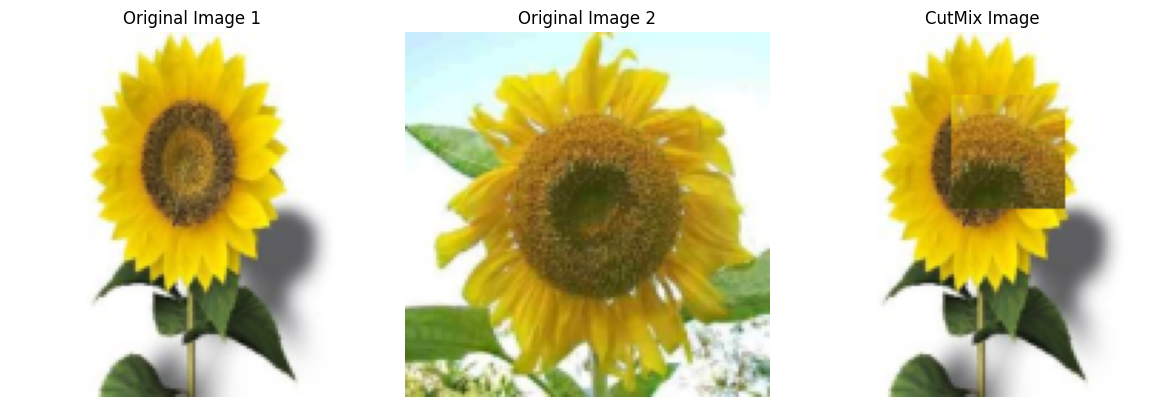

In [9]:
np.random.seed(37)


# Load sample images from the Caltech101 dataset
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])
caltech101 = torchvision.datasets.Caltech101(
    root="./data", download=True, transform=transform
)
dataloader = torch.utils.data.DataLoader(caltech101, batch_size=2, shuffle=True)

img1, label1 = caltech101[7923]  # Get the first image
img2, label2 = caltech101[7929]  # Get the second image


# Display original images
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(img1.permute(1, 2, 0))
axs[0].set_title("Original Image 1")
axs[1].imshow(img2.permute(1, 2, 0))
axs[1].set_title("Original Image 2")

# Apply CutMix and display the mixed image
mixed_img, mixed_label = cutmix_image_and_label(
    img1, label1, img2, label2, beta_distribution=0.32
)
axs[2].imshow(mixed_img.permute(1, 2, 0))
axs[2].set_title("CutMix Image")

for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()